# Sentiment classification of the Standford Movie Review Database

In this tutorial we will be using the handlabelled Standford [movie review database](https://www.cs.cornell.edu/people/pabo/movie-review-data/) (0) to build a sentiment classifier. Our work will highlight how to use [Jupyter Notebooks](https://jupyter.org/) with Python, [Scikit-learn](http://scikit-learn.org/), and [Pandas](http://pandas.pydata.org/) (including [Numpy](http://www.numpy.org/)) to build and crossvalidate a sentiment classifier. We will also throw in a bit of EDA with the help of [Matplotlib](http://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org).

Make sure you have downloaded the movie review data base into the same directory as this notebook under 'review_polarity' (leave the remaining directory file structure intact), and have all the necessary python modules (Numpy, Pandas, Seaborn, Scikit-learn, etc.) loaded.

(0) Bo Pang and Lillian Lee, ``A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts'',  Proceedings of the ACL, 2004

In [25]:
import pandas as pd
import os
import numpy as np

Provide file paths to positive and negative review files

In [4]:
pos_dir = './review_polarity/txt_sentoken/pos'
neg_dir = './review_polarity/txt_sentoken/neg'

The original dataset broke up each review into sentences contained in one file for each review, likely for better feature construction. We want to explore simple sentiment classification, so we have to undo this process.

For each directory, load file, take each line in file and put into one long string, combine it with the associated polarity tag. Do so for all files in the directory. Return a lsit of tuples.

In [5]:
def reviews(polarity_dir, polarity):
    file_list = os.listdir(polarity_dir)
    print len(file_list)
    review_bank = []
    for fname in file_list:
        f = open(os.path.join(polarity_dir, fname))
        file_string = ''
        for line in f:
            line = line.strip('\n')
            file_string = file_string + ' ' + line
        review_bank.append(file_string)
    label_list = [polarity for f in file_list]
    return zip(review_bank, label_list)

In [6]:
pos_reviews = reviews(pos_dir, 1)
neg_reviews = reviews(neg_dir, 0)

1000
1000


##Dealing with Data: DataFrames
Dataframes are convenient format for dealing with small to medium sized data (data which can fit into memory ~8GB). Pandas is a library which implements dataframes for python (largely inspired by the same concept in R). Dataframes are essentially spreadsheets, or objects with data and columns. The columns can hold different types of data, where each row is indexed. From this arrangement, one can do a lot of data munging. From selecting data, dealing with missing values (a.k.a., imputation; very important in the real world of noisey, messy data), simple statistics, time series, to more database-esque type functions: merging, and grouping.

This piece of software is crucial for exploritory data analysis, and quick mockups of classifiers. It is widely used in the industry (check most data science job listings). 

In [7]:
# place the parsed data into a dataframe
review_array = np.concatenate((pos_reviews, neg_reviews), axis=0)
review_df = pd.DataFrame(review_array, columns=['review', 'sentiment'])
# the pandas lib. interprets the sentiment as a string. So we correct
# this.
review_df['sentiment'] = pd.to_numeric(review_df.sentiment)

In [8]:
review_df.tail()

,review,sentiment
1995,"if anything , "" stigmata "" should be taken as...",0
1996,"john boorman's "" zardoz "" is a goofy cinemati...",0
1997,the kids in the hall are an acquired taste . ...,0
1998,there was a time when john carpenter was a gr...,0
1999,two party guys bob their heads to haddaway's ...,0


##Employ a little Exporitory Data Analysis (EDA)

In [9]:
review_df["review_len"] = review_df["review"].apply(lambda x: len(x))
print review_df.head()

                                              review  sentiment  review_len
0   films adapted from comic books have had plent...          1        4227
1   every now and then a movie comes along from a...          1        4096
2   you've got mail works alot better than it des...          1        2421
3    " jaws " is a rare film that grabs your atte...          1        6092
4   moviemaking is a lot like being the general m...          1        3898


:0: FutureWarning: IPython widgets are experimental and may change in the future.


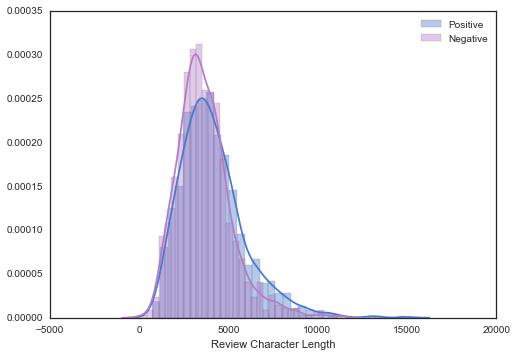

In [10]:
# Plot the distribution of review lengths
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(review_df[review_df["sentiment"] == 1]['review_len'], color='b', label='Positive')
sns.distplot(review_df[review_df["sentiment"] == 0]['review_len'], color='m', label='Negative')
plt.legend()
plt.xlabel('Review Character Length')

You can attempt some for yourself: try to find the most common words in the corpus, and see the overlap with so-called 'stop words'. What should you do if the correlate heavily? What are the most common words from both camps? How much over lap is there?

##Split the data into training and testing data

Splitting data is an important step in any classification process, where one has a hold out set (test set) which the classifier never sees), and one trains the classifier on the training set. A usual split is anywhere between 60/40, and 80/20. Here we choose 75/25.

Be sure to 'stratify' your split, namely, have the same proportion of each class in both the training and test sets, as it is in the whole data set.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(review_df.review.values, review_df.sentiment.values,
                                                    stratify=review_df.sentiment.values, test_size=0.25,
                                                    random_state=42) 

In [12]:
print X_train.shape
print X_test.shape

(1500,)
(500,)


##Feature Creation in NLP Problems

Here we create the usual common features for NLP ML tasks: the bag of words. We construct a dictionary of all words in the training set of reviews. From here, we break down the semantic structure of the review and create a vector whose elemental values correspond to the count of a given word in a review. Therefore, each word is a feature, and the feature space is extremely sparse. Note: we can also save some semantic structure by treating word pairs (bigrams) as features, or generalize this to ngrams.

The transformation of the written word to some numerical representation is important step to using most classifiers in Scikit Learn.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(1500, 434163)

Here we further extend the transformation of the feature space by the inclusion of term-frequency inverse-document transformations. Instead of the raw word-count vector above, we can normalize the counts over the vector, weighting the words with respect to the phrase itself.

Inverse document scaling, scales each word weight in the particular review to how common it is in the corpus (the review data set). More uncommon words are weighted more highly (hence 'inverse' in the transformation name), whereas more common words are weighted less, such as articles in a sentence (these common words are often also noted as 'stop words', see below).

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape


(1500, 434163)

In [15]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1500, 434163)

##Training your Classifier

In [16]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [17]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [18]:
predicted = clf.predict(X_test_tfidf)

In [19]:
# Checking the accuracy of our classifier
from sklearn.metrics import roc_auc_score
print 'ROC Accuracy: ', roc_auc_score(y_test, predicted)

ROC Accuracy:  0.832


In [20]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42).fit(X_train_tfidf, y_train)
predicted = clf.predict(X_test_tfidf)
print 'ROC Accuracy: ', roc_auc_score(y_test, predicted)

ROC Accuracy:  0.804


##Grid Searching

An important part of machine learning is known as hypertuning. This is process of fitting the hyperparameters of your model to the training data.

As always one should also always be cautious of overfitting your data when hypertuning your model. We can circumvent this problem through crossvalidation.

Below, we use a grid search method, to iterate over various combinations of parameters for our different models to find the optimum, cross-validated set of hyperparameters for our data.

In [21]:
from sklearn.model_selection import GridSearchCV
tuning_parameters = {'alpha': [1e-2, 1e-3, 1e-4, 1e-7], 'penalty': ['none', 'l2', 'l1','elasticnet']}
clf = GridSearchCV(SGDClassifier(random_state=42, n_iter=5), tuning_parameters, cv=5, verbose=0, n_jobs=-1,
                   scoring='roc_auc')
clf.fit(X_train_tfidf, y_train)


print("Best parameters set found on training set:")
print(clf.best_params_)
print clf.best_score_

Best parameters set found on training set:
{'penalty': 'elasticnet', 'alpha': 0.0001}
0.921617777778


In [22]:
predicted_SGD = clf.predict(X_test_tfidf)
print roc_auc_score(y_test, predicted_SGD)

0.842


In [23]:
from sklearn.model_selection import GridSearchCV

tuning_parameters = {'alpha': [1e-2, 1e-3, 1e-4, 1e-1,0.25, 0.5, 0.7, 0.9, 1], 'fit_prior':[True, False]}
clf = GridSearchCV(MultinomialNB(), tuning_parameters, cv=5, n_jobs=-1, verbose=0, scoring='roc_auc')
clf.fit(X_train_tfidf, y_train)


print("Best parameters set found on training set:")
print(clf.best_params_)
predicted_mb = clf.predict(X_test_tfidf)
print roc_auc_score(y_test, predicted_mb)

Best parameters set found on training set:
{'alpha': 0.7, 'fit_prior': True}
0.83


##Building Pipelines

Pipelines are useful tools when transforming data, and then fitting it. There is often a fixed series of steps from data to classifier training, and pipelines help this.

Interestingly, one can apply a number of transforms to the data and then apply a classifier. What's interesting, is that this can also be used in conjuction with GridSearcCV (which we applied earlier), to further tune our classifier, and the transformation stage.

Below, we build a pipeline for the SGD classifier, but we include different preprocessing steps; for example, the selection between using only unigrams, or uni-, and bigrams; or whether to weight the ngrams with respect to inverse document frequency, or to use stop words.

In [24]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__stop_words': ('english', None),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (1e-4, 0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (5, 10, 50)
}

In [83]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 69.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 95.3min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 102.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'vect__stop_words': ('english', None), 'vect__max_df': (0.5, 0.75, 1.0), 'clf__penalty': ('l2', 'elasticnet'), 'clf__n_iter': (5, 10, 50), 'clf__alpha': (0.0001, 1e-05, 1e-06)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

##Pipeline Findings
Below we see what the best combination of preprocessing transformations, and then gridsearch, hyperparameters achieve the best trained classifier.

In [54]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.849
Best parameters set:
	clf__alpha: 0.0001
	clf__n_iter: 10
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__stop_words: None


In [58]:
best_parameters['clf']

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=10, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [59]:
best_parameters['vect']

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.75, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Below we apply the best preprocessing transformations to our test data, and then predict the test results from our best trained classifier.

In [61]:
best_vect = best_parameters['vect']
X_test_counts = best_vect.transform(X_test)
X_test_tfidf = best_parameters['tfidf'].transform(X_test_counts)

best_predicted = best_parameters['clf'].predict(X_test_tfidf)

In [62]:
print roc_auc_score(y_test, best_predicted)

0.86


We see a marked increase in accuracy of our classifier, via searching the preprocessing space. The usefulness of Pipelines in Scikit-learn show their worth in this instance.

## Futher improvements
There are a number of things that we can do to improve our classifier, that were mentioned in a previous lecture:
- Inclusion of external semantic libraries
- Incorporating 'part of speech' (POS) tagging.
- Using negation methods
- Using skip n-grams
- Using char n-grams (useful for spelling mistakes)
- Create an ensemble model to play to the features of two or more classifiers

##Further reading and references
- Great tutorial to get into Pandas: [Ten minutes to Pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
- [Jupyter Notebook Guide](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook#gs.PvzdTDk)
- [Introduction to Seaborn](http://seaborn.pydata.org/tutorial.html)